<a href="https://colab.research.google.com/github/vackup/CovidArgentina/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import generales

In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from google.colab import drive
import urllib.request
import json
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Global settings and functions

In [3]:
today = date.today()
days_name_weekends = ['Saturday','Sunday']
base_path = '/content/drive/My Drive/Colab Notebooks/'
path_google_dataset = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

# Use seaborn style defaults and set the default figure size for graphics
sns.set(rc={'figure.figsize':(25, 15)})

In [4]:
def get_df_without_weekends_and_holidays(df, df_feriados):
    df_without_weekends_and_holidays = df[~df.index.isin(df_feriados.index)]
    df_without_weekends_and_holidays = df_without_weekends_and_holidays[~df_without_weekends_and_holidays['Weekday Name'].isin(days_name_weekends)]

    return df_without_weekends_and_holidays

def get_df_only_weekends_and_holidays(df, df_feriados):
    df_only_holidays = df[df.index.isin(df_feriados.index)]
    df_only_weekends = df[df['Weekday Name'].isin(days_name_weekends)]

    df_contat = pd.concat([df_only_weekends, df_only_holidays])

    df_contat = df_contat.sort_index()

    return df_contat

def get_df_only_weekends(df):
    df_only_weekends = df[df['Weekday Name'].isin(days_name_weekends)]

    return df_only_weekends

# note: Apple can unexpectedly change version
def download_apple_report(directory="apple_reports"):
    '''Download Apple Mobility Trends report in CSV

        Args:
            directory: directory to which CSV report will be downloaded

        Returns:
            new_files (bool): flag indicating whether or not a new file has been downloaded
    '''
    version = "v3"
    json_link = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/" + version + "/index.json"
    with urllib.request.urlopen(json_link) as url:
           json_data = json.loads(url.read().decode())
    
    full_path = json_data['regions']['en-us']['csvPath']
    
    link = "https://covid19-static.cdn-apple.com" + json_data['basePath'] + full_path
    new_files = False

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    #file_name = "applemobilitytrends.csv"
    file_name = full_path.split('/')[-1] # last element

    if link[-3:] == "csv":
        path = os.path.join(directory, file_name)
        if not os.path.isfile(path):
            new_files = True
            urllib.request.urlretrieve(link, path)
            print(file_name)
        else:
            path_new = os.path.join(directory, file_name + "_new")
            urllib.request.urlretrieve(link, path_new)
            if os.path.getsize(path) == os.path.getsize(path_new):
                os.remove(path_new)
            else:
                new_files = True
                os.remove(path)
                os.rename(path_new, path)

    if not new_files:
        print('Apple: No updates')

    return new_files, file_name

def get_df_COVID_daily_evolution_from_march2020_argentina():
  df = pd.read_json('https://pomber.github.io/covid19/timeseries.json')
  df2 = pd.DataFrame(df['Argentina'].values.tolist())

  df2['date'] = pd.to_datetime(df2['date'])
  df2 = df2.set_index('date')
  df2 = df2.loc['2020-03-01' : today]
  
  df2['Weekday Name'] = df2.index.day_name()

  return df2

def draw_df_COVID_daily_evolution_from_march2020_argentina(df2):
  cols_plot = ['confirmed', 'deaths', 'recovered']

  fig, ax = plt.subplots()

  ax.plot(df2['confirmed'], marker='o', linestyle='-', label='confirmed')
  ax.plot(df2['deaths'], marker='o', linestyle='-', label='deaths')
  ax.plot(df2['recovered'], marker='o', linestyle='-', label='recovered')
  #ax.plot(df2[cols_plot], marker='o', linestyle='-')

  ax.set_ylabel('Daily Evolution')
  ax.set_title('Covid Argentina evolution')

  ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

  # Format x-tick labels as 3-letter month name and day number
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

  plt.legend(loc="upper left")
  #plt.legend(cols_plot)

  fig.autofmt_xdate()

  for X, Y in zip(df2.index, df2['confirmed']):
      label = "{:.0f}".format(Y)

      ax.annotate(label, # this is the text
                  (X,Y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

  for X, Y in zip(df2.index, df2['deaths']):
      label = "{:.0f}".format(Y)

      ax.annotate(label, # this is the text
                  (X,Y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

  for X, Y in zip(df2.index, df2['recovered']):
      label = "{:.0f}".format(Y)

      ax.annotate(label, # this is the text
                  (X,Y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

def get_df_feriados():
  path_feriados = base_path + 'feriados2020.csv'
  df_feriados = pd.read_csv(path_feriados)

  df_feriados.Fecha = pd.to_datetime(df_feriados.Fecha)

  df_feriados = df_feriados.set_index('Fecha')

  return df_feriados

In [5]:
def draw_df_google_recreation_only_weekends(df_google):
  df_only_weekends = get_df_only_weekends(df_google)

  fig, ax = plt.subplots()

  ax.plot(df_only_weekends['retail_and_recreation_percent_change_from_baseline'], marker='o', linestyle='-', label='retail_and_recreation')
  ax.plot(df_only_weekends['parks_percent_change_from_baseline'], marker='o', linestyle='-', label='parks')
  #ax.plot(df_google_only_weekends_and_holidays['residential_percent_change_from_baseline'], marker='o', linestyle='-', label='residential')

  ax.set_ylabel('Daily Evolution')
  ax.set_title('Google request weekend')

  ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

  # Format x-tick labels as 3-letter month name and day number
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

  plt.legend(loc="upper left")

  fig.autofmt_xdate()

In [6]:
def get_df_apple_mobility_from_march2020_argentina(apple_dataset_file_name):
  path_apple_dataset = base_path + apple_dataset_file_name
  df_apple = pd.read_csv(path_apple_dataset)
  df_apple_argentina = df_apple[df_apple.region.eq("Argentina")]
  df_apple_argentina.drop(columns=['geo_type', 'region', 'alternative_name', 'sub-region', 'country'], inplace=True)
  df_apple_argentina = df_apple_argentina.set_index('transportation_type')
  df_apple_argentina_t = df_apple_argentina.transpose()

  # Converting the index as date
  df_apple_argentina_t.index = pd.to_datetime(df_apple_argentina_t.index)

  df_apple_argentina_t.index.rename('date', inplace=True)

  df_apple_argentina_t = df_apple_argentina_t.loc['2020-03-01' : today]

  df_apple_argentina_t['driving-100'] = df_apple_argentina_t['driving'] - 100
  df_apple_argentina_t['walking-100'] = df_apple_argentina_t['walking'] - 100

  df_apple_argentina_t['Weekday Name'] = df_apple_argentina_t.index.day_name()  

  return df_apple_argentina_t

In [7]:
def draw_df_apple_without_weekends_and_holidays(df_apple):
  df_apple_without_weekends_and_holidays = get_df_without_weekends_and_holidays(df_apple, df_feriados)

  fig, ax = plt.subplots()

  ax.plot(df_apple_without_weekends_and_holidays['driving-100'], marker='o', linestyle='-', label='driving')
  ax.plot(df_apple_without_weekends_and_holidays['walking-100'], marker='o', linestyle='-', label='walking')

  ax.set_ylabel('Daily Evolution')
  ax.set_title('Apple request without weekend day and holidays')

  ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

  # Format x-tick labels as 3-letter month name and day number
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

  plt.legend(loc="upper left")

  fig.autofmt_xdate()

In [8]:
def get_df_google_mobility_from_march2020_argentina():
  df_google = pd.read_csv(path_google_dataset)
  df_google = df_google[df_google.country_region.eq('Argentina')]
  df_google = df_google[~df_google.sub_region_1.notnull()]
  df_google.drop(columns=['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2'], inplace=True)
  df_google.date = pd.to_datetime(df_google.date)
  df_google = df_google.set_index('date')
  df_google = df_google.loc['2020-03-01' : today]
  df_google['Weekday Name'] = df_google.index.day_name()

  return df_google

In [9]:
def draw_df_google_daily_activities_weekdays(df_google, df_feriados):
  df_google_without_weekends_and_holidays = get_df_without_weekends_and_holidays(df_google, df_feriados)

  fig, ax = plt.subplots()

  ax.plot(df_google_without_weekends_and_holidays['grocery_and_pharmacy_percent_change_from_baseline'], marker='o', linestyle='-', label='grocery_and_pharmacy')
  ax.plot(df_google_without_weekends_and_holidays['transit_stations_percent_change_from_baseline'], marker='o', linestyle='-', label='transit_stations')
  ax.plot(df_google_without_weekends_and_holidays['workplaces_percent_change_from_baseline'], marker='o', linestyle='-', label='workplaces')

  ax.set_ylabel('Daily Evolution')
  ax.set_title('Google request without weekend day and holidays')

  ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

  # Format x-tick labels as 3-letter month name and day number
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

  plt.legend(loc="upper left")

  fig.autofmt_xdate()

# Dataset evolucion diaria infectados, muertos y recuperados

In [10]:
# Dataset feriados
df_feriados = get_df_feriados()

df_argentina = get_df_COVID_daily_evolution_from_march2020_argentina()

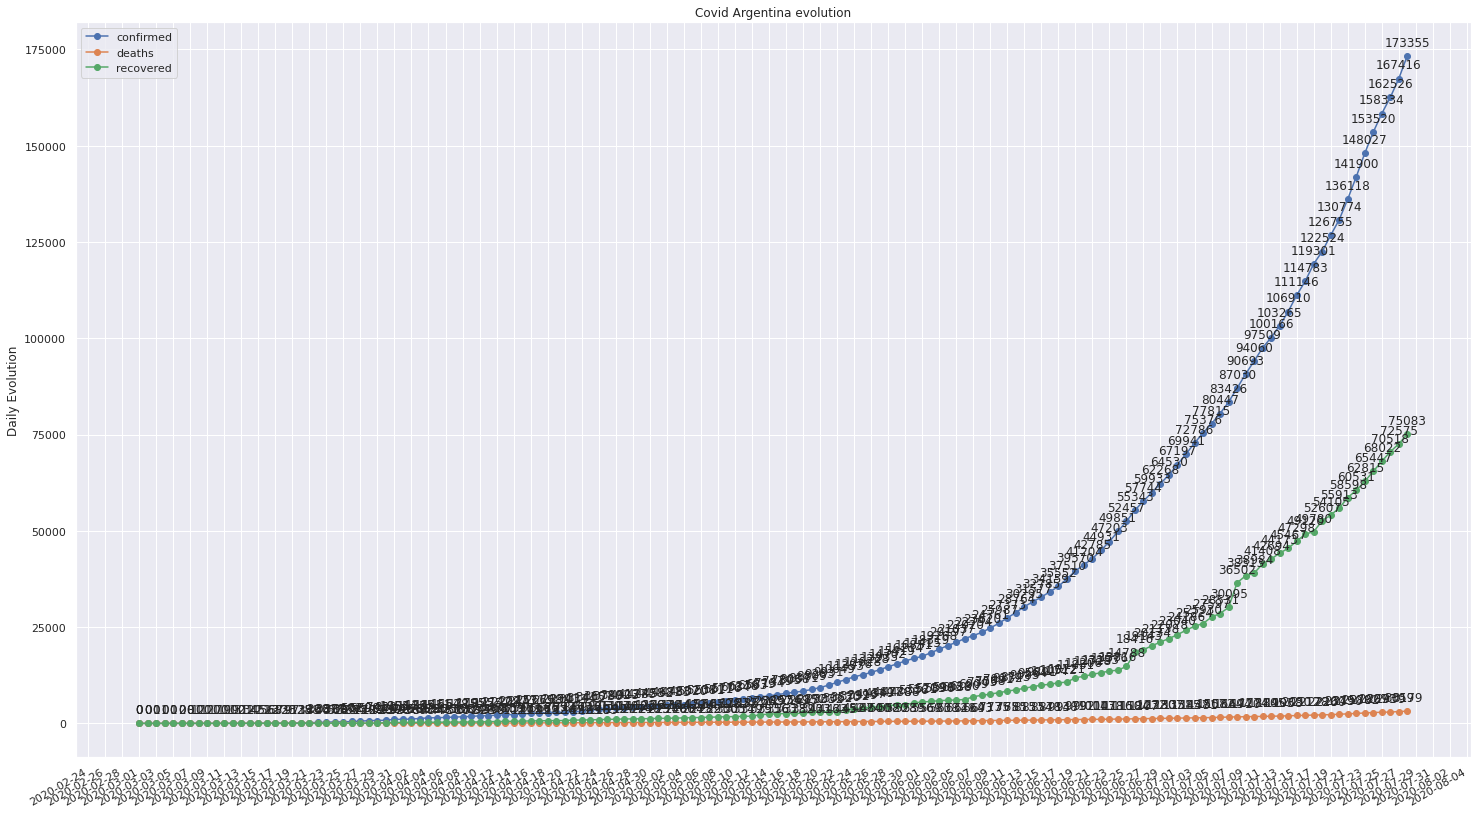

In [11]:
draw_df_COVID_daily_evolution_from_march2020_argentina(df_argentina)

# Download Apple mobility dataset

In [12]:
new_files, apple_dataset_file_name = download_apple_report(base_path)

print(new_files, apple_dataset_file_name)

applemobilitytrends-2020-07-27.csv
True applemobilitytrends-2020-07-27.csv


# Load Datasets

In [13]:
df_apple = get_df_apple_mobility_from_march2020_argentina(apple_dataset_file_name)
df_google = get_df_google_mobility_from_march2020_argentina()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Draw datasets

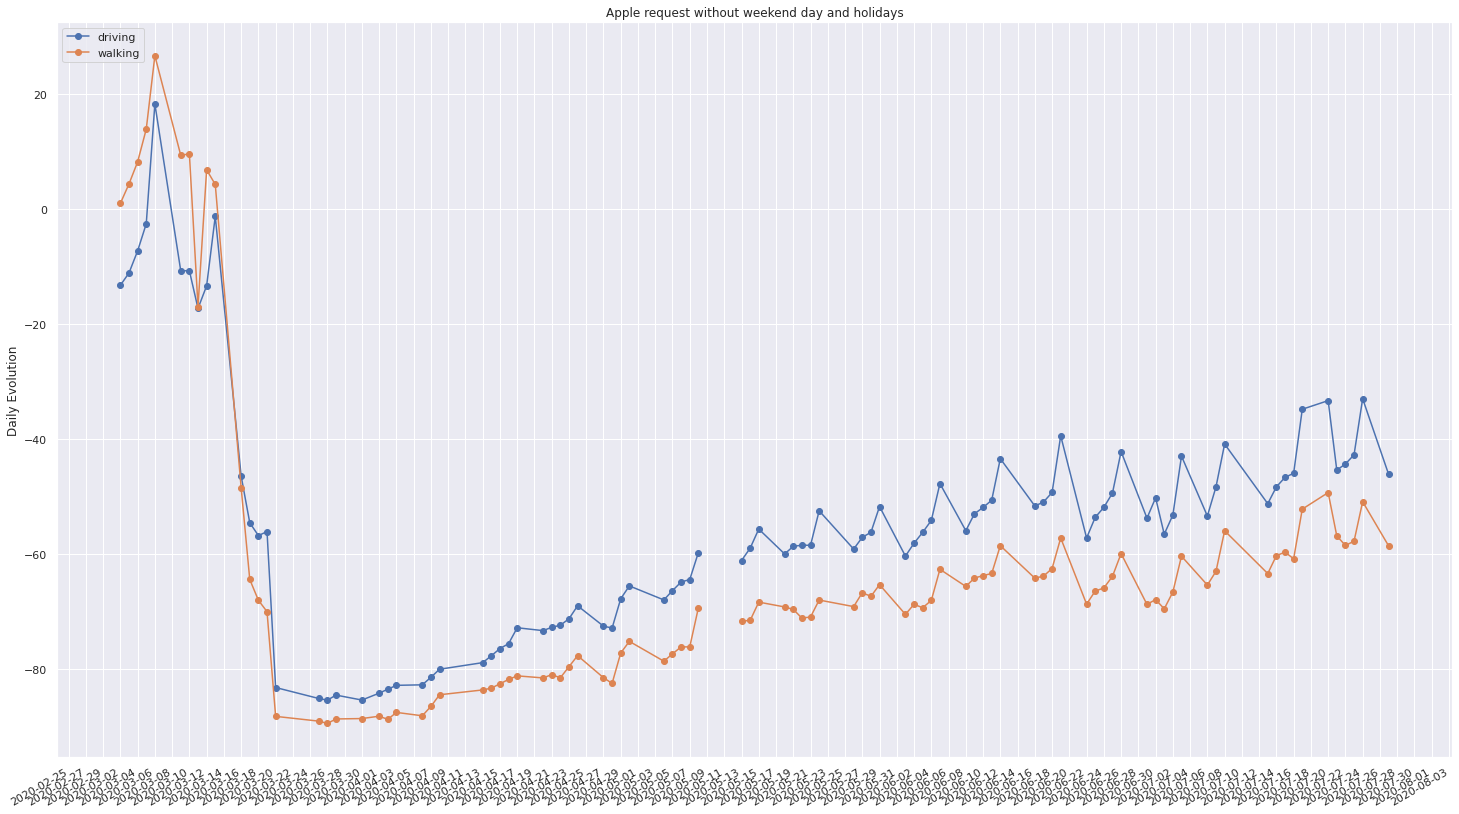

In [14]:
draw_df_apple_without_weekends_and_holidays(df_apple)

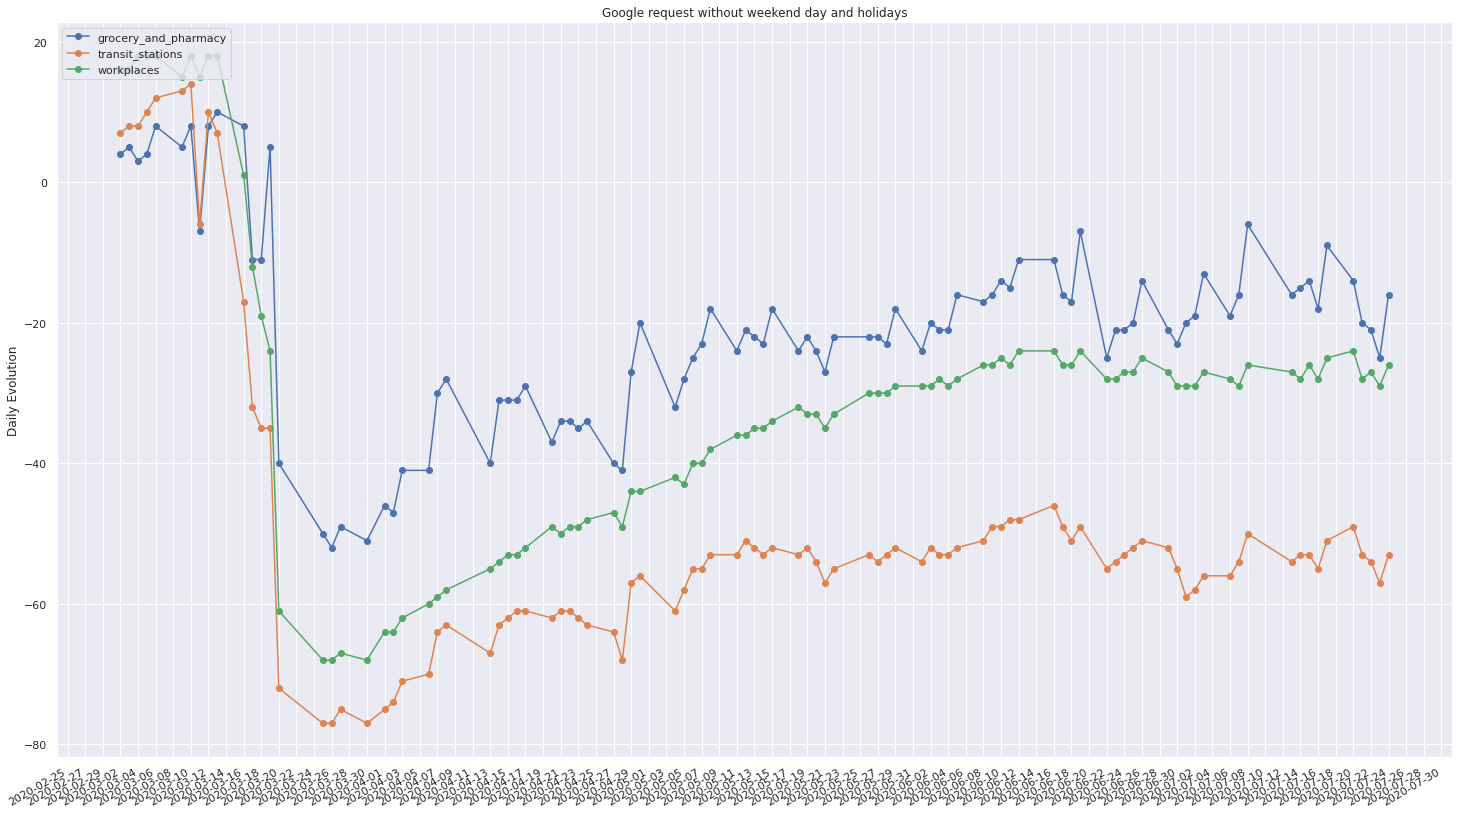

In [15]:
draw_df_google_daily_activities_weekdays(df_google, df_feriados)

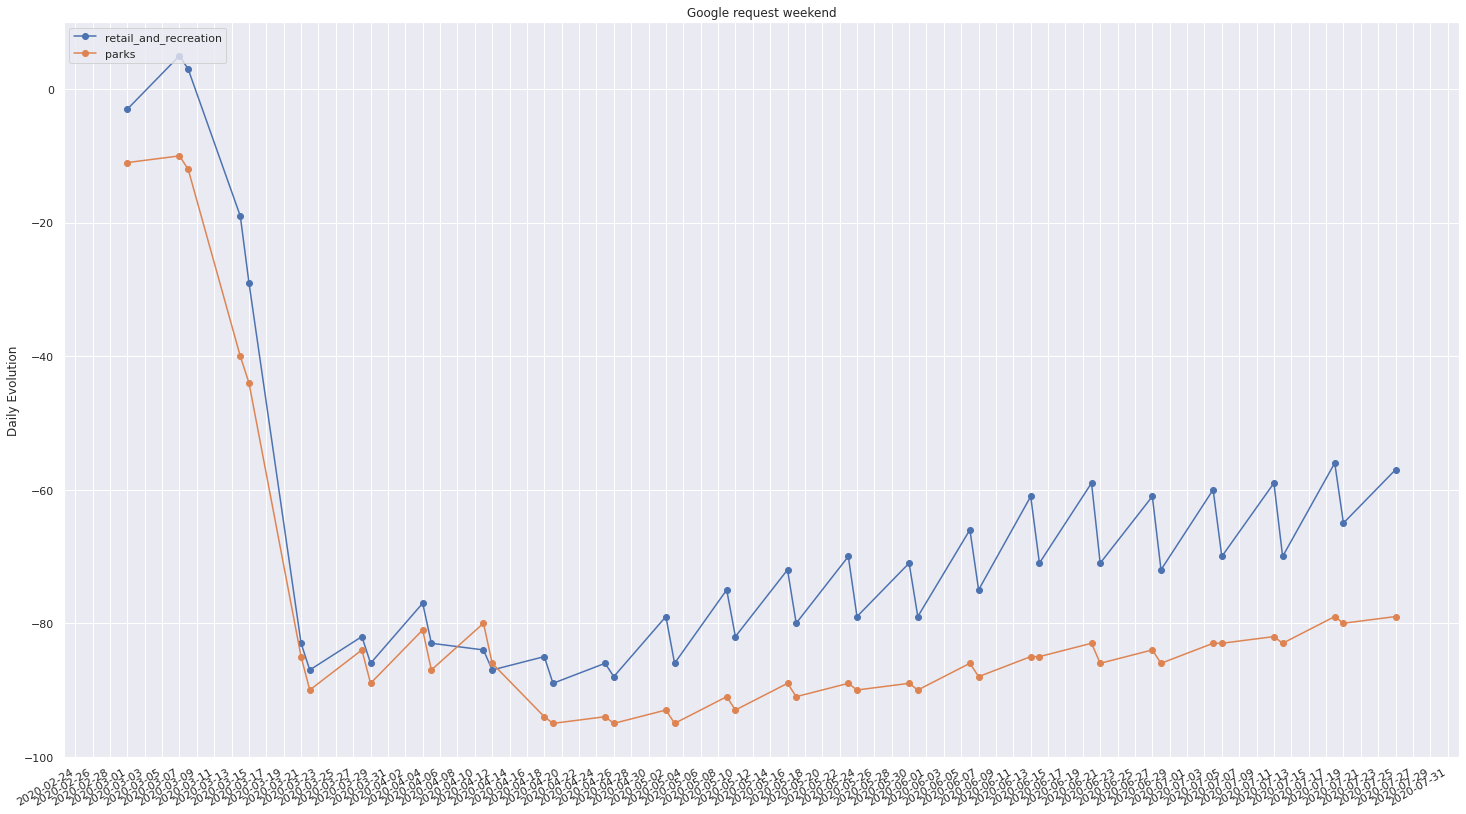

In [16]:
draw_df_google_recreation_only_weekends(df_google)

# Joins all datasets

In [17]:
df_all_datasets = pd.concat([df_argentina, df_google, df_apple], axis=1)

In [18]:
df_all_datasets

,confirmed,deaths,recovered,Weekday Name,metro_area,iso_3166_2_code,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Weekday Name,driving,walking,driving-100,walking-100,Weekday Name
date,,,,,,,,,,,,,,,,,,,
2020-03-01,0,0,0,Sunday,NaN,NaN,NaN,-3.0,3.0,-11.0,1.0,-2.0,2.0,Sunday,81.13,68.50,-18.87,-31.50,Sunday
2020-03-02,0,0,0,Monday,NaN,NaN,NaN,1.0,4.0,-8.0,7.0,16.0,-1.0,Monday,86.76,101.01,-13.24,1.01,Monday
2020-03-03,1,0,0,Tuesday,NaN,NaN,NaN,0.0,5.0,-6.0,8.0,16.0,-1.0,Tuesday,88.90,104.39,-11.10,4.39,Tuesday
2020-03-04,1,0,0,Wednesday,NaN,NaN,NaN,-1.0,3.0,-1.0,8.0,18.0,-2.0,Wednesday,92.74,108.23,-7.26,8.23,Wednesday
2020-03-05,1,0,0,Thursday,NaN,NaN,NaN,1.0,4.0,-9.0,10.0,18.0,-1.0,Thursday,97.45,113.92,-2.55,13.92,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-24,153520,2807,65447,Friday,NaN,NaN,NaN,-57.0,-16.0,-81.0,-53.0,-26.0,19.0,Friday,67.02,49.10,-32.98,-50.90,Friday
2020-07-25,158334,2893,68022,Saturday,NaN,NaN,NaN,-57.0,-12.0,-79.0,-48.0,-16.0,17.0,Saturday,63.70,46.25,-36.30,-53.75,Saturday
2020-07-26,162526,2939,70518,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.80,32.78,-62.20,-67.22,Sunday


Export dataset to Excel and CSV

In [19]:
df_all_datasets.to_excel(base_path + 'all_datasets.xlsx')
df_all_datasets.to_csv(base_path + 'all_datasets.csv')